In [ ]:
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm, trange
import FRED
device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.has_mps else "cpu")
device = torch.device("cpu")
print("Using device", device)
%load_ext autoreload
%autoreload 2

Using device cpu
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Noise Stability Benchmarks

In [ ]:
# Load single cell dataset from scvelo and get associated information
from FRED.datasets import double_helix, directed_swiss_roll_delayed, directed_sinh_branch, rnavelo, rnavelo_pcs
from FRED.data_processing import dataloader_from_ndarray, ManifoldWithVectorField
from torch.utils.data import DataLoader
import scvelo as scv
import os
from pathlib import Path
dataset_name = "pancreas"
# choose correct dataset
Xpath = f"../../data/{dataset_name}/processed/X.txt"
if os.path.exists(Xpath):
    X = np.loadtxt(Xpath)
    flow = np.loadtxt(f"../../data/{dataset_name}/processed/flow.txt")
    labels = np.loadtxt(f"../../data/{dataset_name}/processed/labels.txt")
    latent_time = np.loadtxt(f"../../data/{dataset_name}/processed/latent_time.txt")
else:
    if dataset_name == "bone marrow":
        adata = scv.datasets.bonemarrow()
    elif dataset_name == "dentategyrus":
        adata = scv.datasets.dentategyrus()
    elif dataset_name == "pancreas":
        adata = scv.datasets.pancreas()
    elif dataset_name == "dentategyrus_lamanno":
        adata = scv.datasets.dentategyrus_lamanno()
    print("processing data with pcs")
    X, flow, labels, n_pcs = rnavelo_pcs(adata)
    # dynamical recovery
    scv.tl.recover_dynamics(adata, n_jobs=1)
    scv.tl.latent_time(adata)
    latent_time = adata.obs['latent_time'].to_numpy()
    # save the processed data to np txt files for ready loading in the future
    Path(f"../../data/{dataset_name}/processed").mkdir(parents = True,exist_ok=True)
    np.savetxt(f"../../data/{dataset_name}/processed/X.txt",X)
    np.savetxt(f"../../data/{dataset_name}/processed/flow.txt",flow)
    np.savetxt(f"../../data/{dataset_name}/processed/labels.txt",labels)
    np.savetxt(f"../../data/{dataset_name}/processed/latent_time.txt",latent_time)

In [ ]:
import umap
from FRED.data_processing import dataloader_from_ndarray_V2
from FRED.embed import ManifoldFlowEmbedder
from FRED.trainers import Trainer, visualize_points
from FRED.metrics import silhouette_metric, nn_classification_metric
import sklearn.metrics
def noise_stability_test(
        X, 
        flow, 
        labels, 
        noise_level = 0.1, 
        method = "FRED"):
    """
    Tests the robustness of a method against noise added to both points and flows.
    """
    X = torch.tensor(X).to(device)
    flow = torch.tensor(flow).to(device)
    labels = torch.tensor(labels)
    # add noise to points
    X_noisy = X + torch.rand_like(X)*noise_level*max(torch.linalg.norm(X,axis=1))
    # randomly reverse some percentage of the flow
    flow_noisy = flow
    chosen_idxs = torch.rand(len(flow)) > noise_level
    flow_noisy[chosen_idxs] *= -1
    match method:
        case "UMAP":
            # Fit UMAP (proxy for scvelo)
            reducer = umap.UMAP()
            embedded_points = torch.tensor(reducer.fit_transform(X_noisy.cpu().numpy()))
        case "FRED":
            # Train FRED
            # build dataloader and set up FRED
            dataloader = dataloader_from_ndarray_V2(X_noisy,flow_noisy,labels,batch_size=256)
            MFE = ManifoldFlowEmbedder(
                        embedding_dimension=2,
                        embedder_shape=[X_noisy.shape[1], 20, 10, 5, 2],
                        device=device,
                        sigma=0.5,
                        flow_strength=0.5,
                    )
            loss_weights = {
                        "distance regularization": 100,
                        "contrastive loss v2": 1,
                        "smoothness": 0,
                    }
            visualization_functions = []
            FREDtrainer = Trainer(FE = MFE, 
                    loss_weights=loss_weights, 
                    device=device, 
                    title="Noisy Embedding", 
                    visualization_functions=visualization_functions, 
                    data_type="Contrastive Flow",
                    scheduler=None,
                    learning_rate=1e-3)
            FREDtrainer.fit(dataloader, n_epochs = 300)
            FREDtrainer.visualize_embedding()
            embedded_points = FREDtrainer.embedded_points.detach().cpu().numpy()
        case _:
            raise NotImplementedError("Must Specify UMAP or FRED")
    # Run metrics on points
    silhouette_score = sklearn.metrics.silhouette_score(embedded_points, labels)
    knn_score = nn_classification_metric(embedded_points, np.zeros_like(embedded_points),labels)
    print(f"With noise level {noise_level}, {method} achieved a silhouette score of {silhouette_score} and knn score of {knn_score}")
    return {"silhouette score": silhouette_score, "knn score":knn_score}

In [ ]:
# noise_stability_test(X,flow,labels,noise_level = 0.1, method="UMAP")

In [ ]:
# test UMAP with added noise
umap_silhouettes = []
umap_knn_scores = []
noises = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for ns in tqdm(noises):
    d = noise_stability_test(X,flow,labels,noise_level = ns, method="UMAP")
    umap_silhouettes.append(d["silhouette score"])
    umap_knn_scores.append(d["knn score"])

  0%|          | 0/10 [00:00<?, ?it/s]

With noise level 0.1, UMAP achieved a silhouette score of 0.25704485177993774 and knn score of 0.8852459016393442
With noise level 0.2, UMAP achieved a silhouette score of 0.19270659983158112 and knn score of 0.8213114754098361


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 300/300 [20:01<00:00,  4.01s/it]


With noise level 0.1, FRED achieved a silhouette score of 0.04416755586862564 and knn score of 0.7049180327868853


100%|██████████| 300/300 [19:43<00:00,  3.95s/it]


With noise level 0.2, FRED achieved a silhouette score of 0.02554117701947689 and knn score of 0.6090163934426229


  3%|▎         | 9/300 [00:36<19:47,  4.08s/it]


KeyboardInterrupt: 

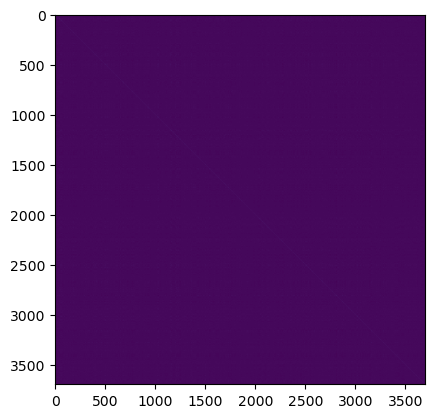

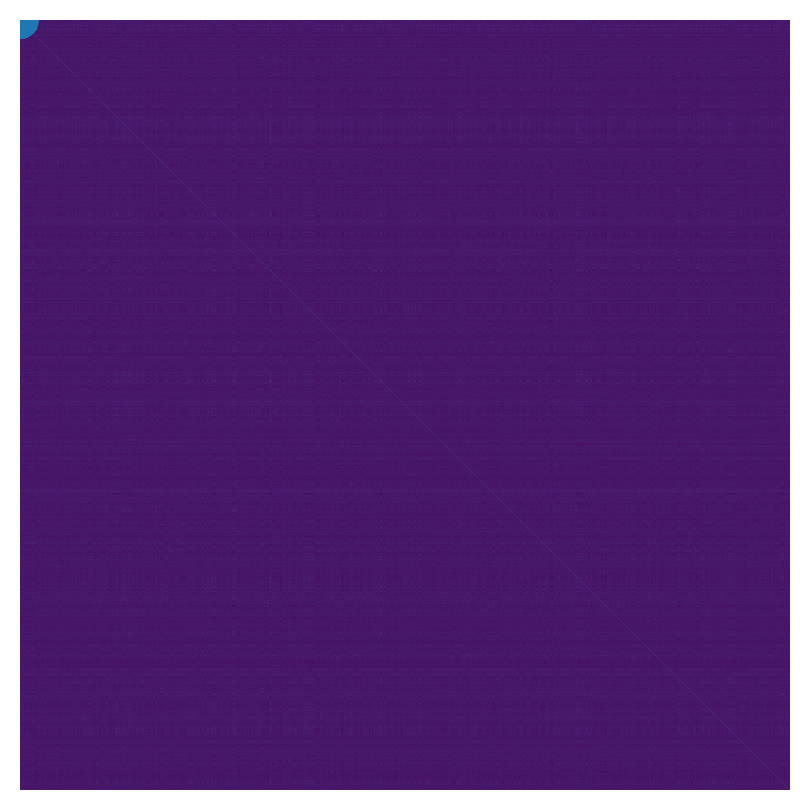

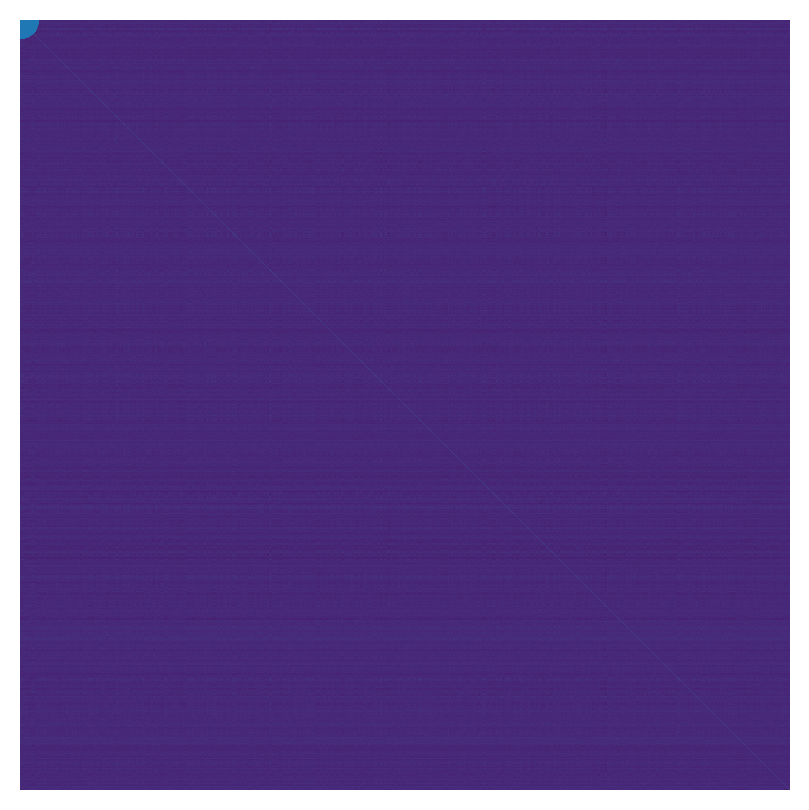

In [ ]:
# test FRED with added noise
fred_silhouettes = []
fred_knn_scores = []
noises = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for ns in tqdm(noises):
    d = noise_stability_test(X,flow,labels,noise_level = ns, method="FRED")
    umap_silhouettes.append(d["silhouette score"])
    umap_knn_scores.append(d["knn score"])

In [ ]:
np.zeros_like